In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [3]:
import pandas as pd
from tqdm.notebook import tnrange, tqdm
import torch
import torchvision
from torch.utils.data import Dataset, TensorDataset
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import models
from PIL import Image
from albumentations import *

In [4]:
torch.cuda.is_available()

True

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Unzip the training data into runtime storage from Google Drive :

In [ ]:
%%bash 
mkdir foldername
tar -xvf '/content/drive/My Drive/train.tar.xz' -C '/content/'

In [7]:
def image_to_nparray(path):
    i = plt.imread(path)    
    return(np.array(i))


## A custom class for this dataset:




In [8]:
class C_Dataset(Dataset):
    """custom"""

    def __init__(self, csv_file_path, root_dir,augmentation=None, transform=None):
        
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        
        self.transform = transform
        self.root_dir = root_dir
        self.d = pd.read_csv(csv_file_path, header= None)[1:]
        self.augmentation = augmentation
    

        
    def __getitem__(self, idx): 

        smol_img_path = str(self.d.iloc[idx][3])
        class_name = str(self.d.iloc[idx][2])[-1] 
        full_img_path = self.root_dir + '/' + 'c'+ class_name + '/' + smol_img_path
        img_arr = image_to_nparray(full_img_path)

        if self.augmentation is not None:
            img  = self.augmentation(image = img_arr)
            img2 = img["image"]

        if self.transform is not None:
            img_ret = self.transform(img2)
        
        return torch.tensor(int(class_name)), img_ret
        

    def __len__(self):
      
        return (len(self.d))

In [9]:
data = C_Dataset('/content/drive/My Drive/balanced.csv', 
                 '/content/train/',
                 augmentation = Compose([ 
                                        RandomBrightnessContrast( p=0.9),
                                        Rotate(limit=20, interpolation=1, border_mode=4, always_apply=False, p=0.5)
                                        ]),
                transform = transforms.Compose([    
                                                transforms.ToPILImage(),
                                                transforms.Resize((224,224), interpolation = Image.NEAREST),
                                                transforms.ToTensor()
                                                ])
                )

val_data = C_Dataset('/content/drive/My Drive/val.csv', 
                     '/content/train/',
                     augmentation = Compose([ 
                                        # VerticalFlip(p=0.5),
                                        # HorizontalFlip(p=0.5),
                                        # RandomBrightnessContrast( p=0.5),
                                        ]),
                     
                transform = transforms.Compose([    
                                                transforms.ToPILImage(),
                                                transforms.Resize((224,224), interpolation = Image.NEAREST),
                                                transforms.ToTensor()
                                                ])
                )

train_set, val_set = data, val_data
print(len(train_set), len(val_set))

23890 1000


## Plot Augmented Samples from the Train-Loader :


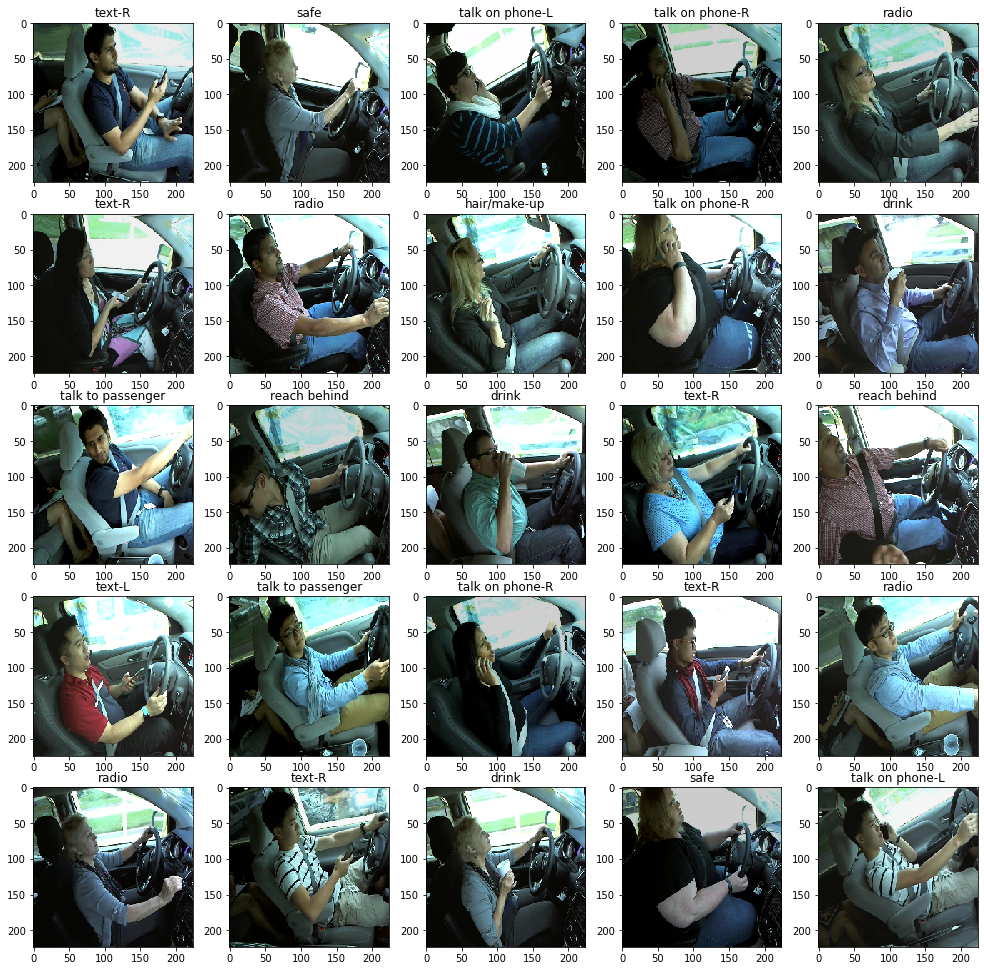

<Figure size 720x216 with 0 Axes>

<Figure size 3600x3600 with 0 Axes>

In [10]:
train_loader_1 = torch.utils.data.DataLoader(
    train_set
    ,batch_size=10
    ,shuffle=True
)

class_list = ['safe', 'text-R', 'talk on phone-R', 'text-L', 'talk on phone-L', 'radio', 'drink'
, 'reach behind', 'hair/make-up', 'talk to passenger']
fig, axs = plt.subplots(5, 5, figsize=(17,17))
fig = plt.figure(figsize=(10,3))
trans = transforms.ToPILImage()
plt.figure(figsize=(50,50))

for i in range(5):
    for j in range(5):
        for labels,images in (train_loader_1):

            x=np.transpose(images[0], (1, 2, 0))  
            class_number = labels[0].item()
            im_label=class_list[class_number]
            axs[j,i].imshow(x, interpolation='none')
            axs[j,i].title.set_text(im_label)
            
            break
plt.show()

## A function to compute the number of correct predictions :


In [11]:
def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

## A function to plot the training metrics :

In [29]:
def plot_metric(arg, frm):
    
    if (arg)=='loss':
        a,b = loss_list, val_loss_list
    elif (arg)=='accuracy':
        a,b=acc_list, val_acc_list
            
    width_height = (11,3)
    plt.figure(figsize=width_height)

    plt.axvspan(4,6, color='red', alpha=0.2)
    
    plt.plot(a[frm:], label='Training ' + str(arg))
    plt.plot(b[frm:], label='Validation ' + str(arg))
    plt.xlabel(str(arg))
    plt.ylabel("Epochs")
    plt.grid()
    plt.legend()
    plt.show()

## The Model :

In [ ]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 10)

network = model_ft.to(device)
print(network)

In [15]:
train_loader_2 = torch.utils.data.DataLoader(
    train_set
    ,batch_size=15
    ,shuffle=True
    ,num_workers=8
)

val_loader = torch.utils.data.DataLoader(
    val_set, 
    batch_size=128, 
    shuffle=True,
    num_workers=8
)

loss_list=[]
acc_list=[]
val_loss_list=[]
val_acc_list=[]


optimizer = optim.Adam(network.parameters(), lr=0.000045) #lr=0.00003
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=2)

## Training Loop :

In [47]:
for epoch in tnrange(1):
    
    total_loss = 0
    total_correct = 0
    total_loss2 = 0
    total_correct2 = 0
    
    j
    with torch.no_grad():
        network.eval()
        for batch2 in (val_loader): # Get Batch

            labels2, images2 = batch2
            images2=images2.to(device)
            labels2=labels2.to(device)
            
            preds2 = network(images2) # Pass Batch
        
            loss2 = F.cross_entropy(preds2, labels2)
            
            total_loss2 += loss2.item()
            total_correct2 += get_num_correct(preds2, labels2)

    for batch in tqdm(train_loader_2): # Get Batch

        labels, images = batch
        images=images.to(device)
        labels=labels.to(device)

        preds = network(images)
        
        loss = F.cross_entropy(preds, labels)
        optimizer.zero_grad()
        loss.backward() # Calculate Gradients
        optimizer.step()  
        total_loss += loss.item()
        total_correct += get_num_correct(preds, labels)
                                                       
    loss_list.append(total_loss/(len(train_set))) 
    acc_list.append(total_correct/(len(train_set)))
    val_loss_list.append(total_loss2/(len(val_set)))
    val_acc_list.append(total_correct2/(len(val_set)))

## The Metrics :

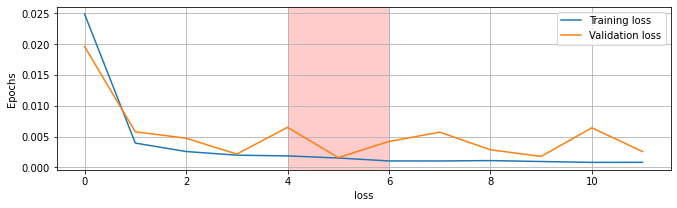

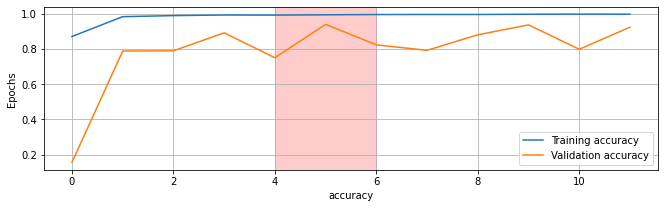

In [45]:
plot_metric('loss', 0) 
plot_metric('accuracy', 0)

In [3]:
print(max(val_acc_list)*100, "% Accuracy")

93.9 % Accuracy


In [41]:
torch.save(network.state_dict(), 'model_res18_939.pt') #saved after 5th epoch.